In [2]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm
from DataPrep import data_prep, exp_data_collection, get_test_data

# from Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel
from InitialData_Gen import initialize
from AcquisitionFunctions import EI, PI, UCB, AcquisitionOnSubspace
# from SamplingCategorical import compute_prob_dist_and_draw_hts
from UpdateCategoricalWeight import compute_reward_for_all_cat_variable, update_weights_for_all_cat_var
from optimization import sample_then_minimize

from AskTell import ask_tell

from scipy.optimize import minimize

from typing import Union, Tuple
from paramz.transformations import Logexp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [3]:
import sys
myString = sys.path[0]
split_list = myString.split("/")
root = ''
for l in split_list[1:-2]:
    root = root +'/'+ l
    
main_file_path = root + '/Trastuzumab/'
carbon_source_fiepath = root + '/'

In [4]:
Stock_solid = pd.read_excel(carbon_source_fiepath + 'CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel(carbon_source_fiepath + 'CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])

Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

OG_Gly_Ub = 100 #[mL/L]
Met_Ub = 100 #[mL/L]

Glu_Ub = 50 #mM
Tween_Ub = 1# 1%
pH_Ub = 6.5# 

Stock_Conc = Stock_solid['g/mL'].values.tolist()
Stock_Conc.append(Stock_liquid['mL/mL'][1].tolist())
Stock_Conc.append(Stock_liquid['mL/mL'][2].tolist())

OG_Stock_Conc = Stock_liquid['mL/mL'][0].tolist()

Glu_Stock_Conc = 250 #mM
Tween_Stock_Conc = 50# %
pH_Stock_Conc = 1# 

In [5]:
property_name = 'Specific Productivity'
N_round_input = 6
Rounds_bfr_check = 6
cut_off_round = 6
cont_kernel = 'Matern52'

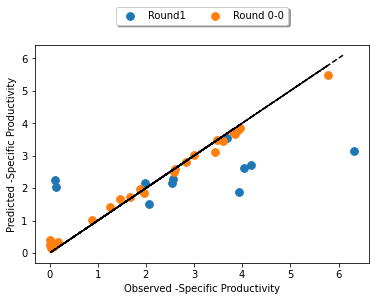

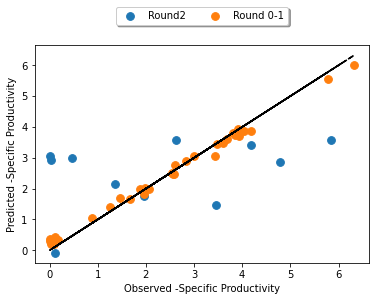

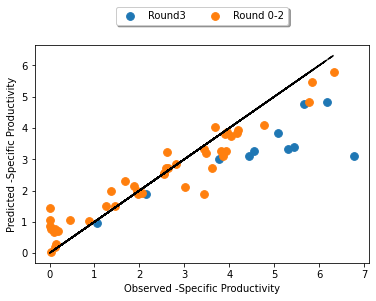

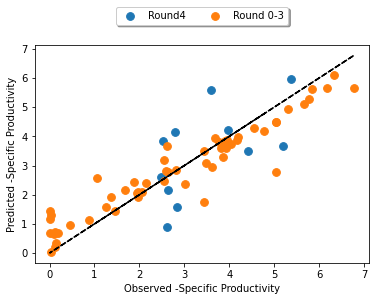

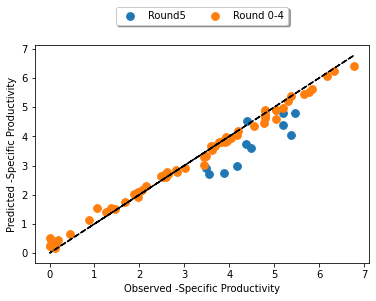

Why did I come here


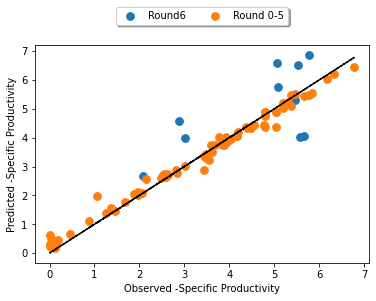

In [6]:
Train, Train_Std, Pred, Pred_Std, RMSEP, result_ts, Design, data, result = data_prep(main_file_path, 
                                                               N_round_input, Rounds_bfr_check,cut_off_round, property_name)


In [ ]:
from AskTell import get_kernel, Scaling_data

cont_kernel_name = 'Matern52'

background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
with open(background_file, "rb") as fp:
    ModelBackground_0 = pickle.load(fp)
        
ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 
ModelBackground_0['data_param']['Meas_Noise'] = 0.1       
        
k_CoCaBO = get_kernel(ModelBackground_0['data_param'], cont_kernel_name)

ModelBackground_0['data_param']['approach_type'] = 'Co'
ModelBackground_0['data_param']['nDim'] = 21

k_cont = get_kernel(ModelBackground_0['data_param'], cont_kernel_name)

mu_x, std_x, mu_y, std_y, data_norm, result_norm = Scaling_data(data[6], result[6])
data_norm[:,0:1] = data[6][:, 0:1]

categorical_OH = np.zeros((data_norm.shape[0], 19))
for i in range(data_norm.shape[0]):
    categorical_OH[i,int(data[6][i,0])] = 1

data_norm_OH = np.concatenate((categorical_OH[:,:-1], data_norm[:,1:]), axis =1)

In [ ]:
n_samp = 50
n_ts = 1
RMSEF = np.zeros((n_samp*n_ts,4))
RMSEP = np.zeros((n_samp*n_ts,4))
cnt = 0
for m in [0.33]:
    for i in range(n_samp):
        X_train, X_test, y_train, y_test = train_test_split(data_norm, result_norm, test_size=m, random_state=i)
    
        gp_CoCaBO =  GPy.models.GPRegression(X_train, y_train, k_CoCaBO)#GPy.core.gp.GP(data, result, my_kernel, )
        gp_CoCaBO.optimize(max_iters=10000)
        
        y_pred_tr = np.mean(gp_CoCaBO.posterior_samples_f(X_train, 10000), 2)
        y_pred_ts = np.mean(gp_CoCaBO.posterior_samples_f(X_test, 10000), 2)
        
        y_train_unsc = y_train * std_y + mu_y
        y_test_unsc = y_test * std_y + mu_y
        y_pred_tr_unsc = y_pred_tr * std_y + mu_y
        y_pred_ts_unsc = y_pred_ts * std_y + mu_y
        
        RMSEF[i+cnt*n_samp,0] = np.sqrt(MSE(y_train_unsc,y_pred_tr_unsc))
        RMSEP[i+cnt*n_samp,0] = np.sqrt(MSE(y_test_unsc,y_pred_ts_unsc))
        
        RMSEF[i+cnt*n_samp,1] = cnt
        RMSEP[i+cnt*n_samp,1] = cnt
        
        RMSEF[i+cnt*n_samp,2] = 0
        RMSEP[i+cnt*n_samp,2] = 1
        
        RMSEF[i+cnt*n_samp,3] = 0
        RMSEP[i+cnt*n_samp,3] = 0
        
    cnt = cnt + 1

In [ ]:
n_samp = 50
RMSEF_OH = np.zeros((n_samp*n_ts,4))
RMSEP_OH = np.zeros((n_samp*n_ts,4))
cnt = 0
for m in [0.33]:
    for i in range(n_samp):
        X_train, X_test, y_train, y_test = train_test_split(data_norm_OH, result_norm, test_size=m, random_state=i)
    
        gp_OH =  GPy.models.GPRegression(X_train, y_train, k_CoCaBO)#GPy.core.gp.GP(data, result, my_kernel, )
        gp_OH.optimize(max_iters=10000)
        
        y_pred_tr = np.mean(gp_OH.posterior_samples_f(X_train, 10000), 2)
        y_pred_ts = np.mean(gp_OH.posterior_samples_f(X_test, 10000), 2)
        
        y_train_unsc = y_train * std_y + mu_y
        y_test_unsc = y_test * std_y + mu_y
        y_pred_tr_unsc = y_pred_tr * std_y + mu_y
        y_pred_ts_unsc = y_pred_ts * std_y + mu_y
        
        RMSEF_OH[i+cnt*n_samp,0] = np.sqrt(MSE(y_train_unsc,y_pred_tr_unsc))
        RMSEP_OH[i+cnt*n_samp,0] = np.sqrt(MSE(y_test_unsc,y_pred_ts_unsc))
        
        RMSEF_OH[i+cnt*n_samp,1] = cnt
        RMSEP_OH[i+cnt*n_samp,1] = cnt
        
        RMSEF_OH[i+cnt*n_samp,2] = 0
        RMSEP_OH[i+cnt*n_samp,2] = 1
        
        RMSEF_OH[i+cnt*n_samp,3] = 1
        RMSEP_OH[i+cnt*n_samp,3] = 1
        
    cnt = cnt + 1

In [ ]:
df = pd.concat((pd.DataFrame(RMSEP), pd.DataFrame(RMSEP_OH)), axis = 0)
df.columns = ['RMSE', 'Ts_Ratio', 'Tr/Ts','kcat/OH']

In [ ]:
# import seaborn as sns
# params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
# hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
# plt.rcParams.update(params)
# plt.rcParams["figure.figsize"] = (12, 4)
# f, ax = plt.subplots(1, 1)

# sns.violinplot(data =df, x = 'Ts_Ratio', y = 'RMSE', hue = 'kcat/OH')

In [ ]:
plt_data = np.concatenate((RMSEP[:,0:1], RMSEP_OH[:,0:1]), axis = 1)


herA_error_chart = {'HerceptinA': plt_data}
import pickle
with open('HerA_Kernel.pkl', 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(herA_error_chart, output)

In [ ]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value



plt_data = np.concatenate((RMSEP[:,0:1], RMSEP_OH[:,0:1]), axis = 1)
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (4, 4)
f, ax = plt.subplots(1, 1)
parts = plt.violinplot(plt_data, showmeans=False, showmedians=False,
        showextrema=False)

cnt = 0
alpha_list = [0.7, 0.5]
for pc in parts['bodies']:
    print(pc)
    pc.set_facecolor('tan')
    pc.set_edgecolor('black')
    
    pc.set_alpha(alpha_list[cnt])
    cnt = cnt+1
    

quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


labels = ['Kernel Design',  'OHE']
ax.set_xlim([0.5,2.5])
ax.set_xticks([1, 2])
ax.set_xticklabels(labels, **hfont)
ax.set_yticks([0, 0.5,1, 1.5, 2, 2.5, 3])
ax.set_yticklabels(['', 0.5,1, 1.5, 2, 2.5, 3], **hfont)
ax.set_ylabel("RMSEP \n (Specific Productivity)", **hfont)

plt.savefig("HerA.pdf", dpi = 600, bbox_inches = "tight")

In [ ]:
parts['bodies']

In [ ]:
plt_data 

### Kernel_parameters

In [6]:
gp_actual = {}

for n in [1]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    
    z_next, Categorical_dist_param, gp_actual = ask_tell(data[n][:-19,:], result[n][:-19], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure

check2
  index  |  Mat52.lengthscale  |  constraints  |  priors
  [0]    |         1.00000000  |      +ve      |        
  [1]    |         1.00000000  |      +ve      |        
  [2]    |         1.00000000  |      +ve      |        
  sum.                                       |  value  |  constraints  |  priors
  MixtureViaSumAndProduct.mix                |    0.5  |      +ve      |        
  MixtureViaSumAndProduct.Mat52.lengthscale  |   (3,)  |      +ve      |        
  white.variance                             |    0.1  |   +ve fixed   |        
  sum.                                       |               value  |  constraints  |  priors
  MixtureViaSumAndProduct.mix                |  0.2521314600945254  |      +ve      |        
  MixtureViaSumAndProduct.Mat52.lengthscale  |                (3,)  |      +ve      |        
  white.variance                             |                 0.1  |   +ve fixed   |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengt

KeyboardInterrupt: 

In [ ]:
gp_actual = {}

for n in [6]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    
    for i in np.arange(1, n+1):
        if i == 1:
            data_trim = data[i][:-19]
            res_trim = result[i][:-19]
        else:
            data_trim = np.concatenate((data_trim, data[i][-19-11:-19]), axis = 0)
            res_trim = np.concatenate((res_trim, result[i][-19-11:-19]), axis = 0)

    z_next, Categorical_dist_param, gp_actual = ask_tell(data_trim, res_trim, ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure
 

In [ ]:
data_trim.shape

In [ ]:
for n in [3]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    
    if n <=4:

        z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure
    else:
        z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Categorical_dist_param']['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure

    

In [ ]:
for n in [4]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    
    if n <=4:

        z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure
    else:
        z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Categorical_dist_param']['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure

    

In [ ]:
for n in [5]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    
    z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure

In [ ]:
for n in [6]:
    batch_size = 1
    
    if N_round_input == 6:
        background_file = main_file_path +  "Codes/Round5/5_ModelBackground.pkl"
    else:
        background_file = main_file_path +  "Codes/Round"+ str(n-1)+"/" +str(n-1)+ "_ModelBackground.pkl"
    
    
    with open(background_file, "rb") as fp:
        ModelBackground_0 = pickle.load(fp)
        
    ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


    ModelBackground_0['data_param']['Meas_Noise'] = 0.1

    random.seed(0)
    

    z_next, Categorical_dist_param, gp_actual = ask_tell(data[n], result[n], ModelBackground_0['data_param'], 
                                                  'Matern52', 'constant_liar_pure',  batch_size, 
                                                   ModelBackground_0['Wc_list'],  
                                                  ModelBackground_0['gamma_list']) #_pure

    